In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
import os

In [2]:
os.chdir('../plots')

In [3]:
f_bins = 100
t_bins = 100
t_min = 0.0
t_max = 50
f_min = 10
f_max = 200
t=np.linspace(t_min, t_max, t_bins)
f=np.linspace(f_min, f_max, f_bins)

In [4]:
def get_aspect(extent, shape):
    
    x_res = (extent[0] - extent[1])/shape[0]
    y_res = (extent[2] - extent[3])/shape[1]
    
    return x_res/y_res

In [5]:
def plot_spectrogram(img, t_min, t_max, f_min, f_max, name=None):
    
    fig, ax = plt.subplots()    

    extent = [t_min, t_max, f_min, f_max]
    aspect = get_aspect(extent, img.shape)
    
    ax.imshow(np.transpose(img), extent=extent, origin='lower', aspect=aspect)
    ax.set_xlabel('t')
    ax.set_ylabel('f')
    
    if name:
        plt.savefig(name+'.png', dpi=1200)
        
    plt.show()

In [6]:
def line(m, b, x):
    return m*x + b

def line_segment(t_start, t_end, f_start, f_end):
    
    dt = t_end - t_start
    df = f_end - f_start
    
    m = df/dt
    b = f_end - m*t_end
    
    return lambda x: line(m, b, x)

def get_b_m(t_start, t_end, f_start, f_end):
    
    dt = t_end - t_start
    df = f_end - f_start
    
    m = df/dt
    b = f_end - m*t_end
    
    return b, m

In [7]:
def gauss(y, mu, sigma):
    
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(y-mu)**2/sigma)

In [8]:
def get_track_signal(signal, t, f, track):
    
    track_signal = np.zeros(shape=signal.shape)
    
    track_ind = (t>(track.t_start))&(t<(track.t_end))
    
    t_track = t[track_ind]
    
    ff, tt = np.meshgrid(f, t_track)
    
    mu = line_segment(track.t_start, track.t_end, track.f_start, track.f_end)
    
    track_signal[track_ind] = gauss(ff, mu(tt), track.sigma)
    
    return track_signal

In [9]:
class Track:
    
    def __init__(self, t_start, t_end, f_start, f_end, sigma, snr):
        self.t_start = t_start
        self.t_end = t_end
        self.f_start = f_start
        self.f_end = f_end
        self.sigma = sigma
        self.snr = snr
    
    def get_delta(self):
        
        dt = self.t_end - self.t_start
        df = self.f_end - self.f_start
        
        return dt, df
    
    def get_slope(self):
        
        dt, df = self.get_delta()

        return df/dt
    
    def get_length(self):

        dt, df = self.get_delta()
        
        return np.sqrt(df**2 + dt**2)
    
    @classmethod
    def from_slope_and_length(cls, t_start, f_start, slope, length, sigma, snr):
        
        #alpha = np.arctan(slope)
        #df = np.sin(alpha)*length
        #dt = np.cos(alpha)*length
        dt = length
        df = dt*slope
        return cls(t_start, t_start+dt, f_start, f_start+df, sigma, snr)
        

In [10]:
def get_spectrogram(tracks, t, f):
    
    signal = np.zeros((t.shape[0], f.shape[0]))
    
    for track in tracks:
        signal += track.snr*get_track_signal(signal, t, f, track)
        
    noise = np.random.exponential(1, (t.shape[0], f.shape[0]))
    
    return signal + noise

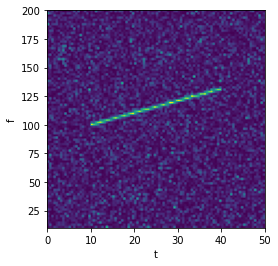

In [12]:
snr = 35
sigma = 1.5
t_start = 10
f_start = 100
length = 30
slope = 1.05
img_name = 'hi_snr_long'

tracks=[Track.from_slope_and_length(t_start, f_start, slope, length, sigma, snr)]
       #Track(40, 45, 160, 170, sigma, 40)] #, Track(10, 20, 145, 149), Track(20, 35, 250, 256), Track(35, 37, 400, 401)]
img = get_spectrogram(tracks, t, f)

plot_spectrogram(img, t_min, t_max, f_min, f_max, img_name)

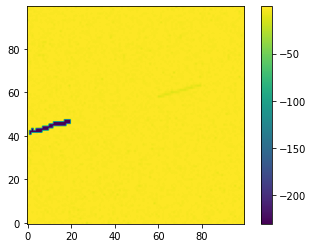

In [29]:
dt = -10
likelihood_img = get_likelihood_vals(img, t, f, 
                                     Track.from_slope_and_length(t_start+dt, f_start+dt*slope, 
                                                                 slope, length, sigma, snr))

cmap = plt.imshow(np.transpose(likelihood_img), origin='lower')
plt.colorbar(cmap)
plt.show()

In [30]:
def get_likelihood_vals(spectrogram, t, f, track):
    intensity_0 = get_track_signal(spectrogram, t, f, track)
  #  noise_part = spectrogram - track.snr*intensity_0
  #  probabilities = exp_prob(noise_part)
    probabilities = expon.pdf(spectrogram, loc=track.snr*intensity_0)
    
    return np.log(np.maximum(probabilities, 1e-100))

In [31]:
def get_likelihood(spectrogram, t, f, track):
    
    return - np.sum(get_likelihood_vals(spectrogram, t, f, track))

In [32]:
def scan_likelihood(scan_vals, likelihood_function):
    lh = []
    for val in scan_vals:
        lh.append(likelihood_function(val))
    
    return lh

In [33]:
def scan_likelihood_2d(scan_vals_x, scan_vals_y, likelihood_function):
    lh = []
    for x in scan_vals_x:
        lhx = []
        for y in scan_vals_y:
            lhx.append(likelihood_function(x,y))
        lh.append(lhx)
    
    return lh

In [34]:
def scan_and_plot(lh_func, x_min, x_max, dx, x_real, label, name):
    scan_vals = np.arange(x_min, x_max, dx)
    lh_res = scan_likelihood(img, scan_vals, lh_func)

    fig, ax = plt.subplots()
    ax.plot(scan_vals, lh_res)
    ax.vlines([x_real], min(lh_res), max(lh_res), color='r', ls='--', label='real '+ label)
    ax.set_xlabel(label)
    ax.set_ylabel('-loglikelihood')
    ax.legend(loc='best')
    plt.savefig(name + '_' + label + '_scan.png', dpi=600)
    plt.show()

In [59]:
def scan_and_plot_2d(lh_func, x_min, x_max, dx, x_real, y_min, y_max, dy, y_real, x_label, y_label, name):
    scan_vals_x = np.arange(x_min, x_max, dx)
    scan_vals_y = np.arange(y_min, y_max, dy)
    
    lh_np = np.array(scan_likelihood_2d(scan_vals_x, scan_vals_y, lh_func))
    
    min_ind = np.unravel_index(lh_np.argmin(), lh_np.shape)
    
    print("True vals: ", x_real, y_real, "Found minimum: ", scan_vals_x[min_ind[0]], scan_vals_y[min_ind[1]])
    
    fig, ax = plt.subplots()
    extent = [scan_vals_x[0],scan_vals_x[-1],scan_vals_y[0],scan_vals_y[-1]]
    aspect = get_aspect(extent, lh_np.shape)
    im=ax.imshow(lh_np, origin='lower', extent= extent, aspect=aspect)
    ax.plot(x_real, y_real, marker='x', c='r')
    ax.plot(scan_vals_x[min_ind[0]], scan_vals_y[min_ind[1]], marker='v', c='g')
    cbar = fig.colorbar(im)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    cbar.set_label('log-likelihood')
    plt.savefig(name + '_' + x_label + '_' + y_label +'_scan.png',dpi=600)
    plt.show()

True vals:  10 100 Found minimum:  9.969999999999958 99.96000000000254


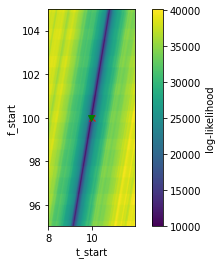

In [61]:
lh_func = lambda x, y: get_likelihood(img, t, f, 
                                       Track.from_slope_and_length(x, y, slope, length, sigma, snr))
scan_and_plot_2d(lh_func, t_start-2, t_start+2, 0.01, t_start, f_start-5, f_start+5, 0.01, f_start, 't_start', 'f_start', img_name)

In [ ]:
lh_func = lambda x: get_likelihood(img, t, f, 
                                       Track.from_slope_and_length(t_start, f_start, x, length, sigma, snr))
scan_and_plot(lh_func, 0.1, 3.33, 0.01, slope, 'slope', img_name)

lh_func = lambda x: get_likelihood(img, t, f, 
                                       Track.from_slope_and_length(t_start, f_start, slope, x, sigma, snr))
scan_and_plot(lh_func, 0.1, 50, 0.1, length, 'length', img_name)

lh_func = lambda x: get_likelihood(img, t, f, 
                                       Track.from_slope_and_length(t_start, f_start, slope, length, sigma, x))
scan_and_plot(lh_func, 0.1, 35, 0.1, snr, 'snr', img_name)

lh_func = lambda x: get_likelihood(img, t, f, 
                                       Track.from_slope_and_length(t_start, f_start, slope, length, x, snr))
scan_and_plot(lh_func, 0.1, 5, 0.01, sigma, 'sigma', img_name)

lh_func = lambda x: get_likelihood(img, t, f, 
                                       Track.from_slope_and_length(x, f_start, slope, length, sigma, snr))
scan_and_plot(lh_func, t_min, t_max, 0.01, t_start, 't_start', img_name)

lh_func = lambda x: get_likelihood(img, t, f, 
                                       Track.from_slope_and_length(t_start, x, slope, length, sigma, snr))
scan_and_plot(lh_func, f_min, f_max, 1, f_start, 'f_start', img_name)